# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

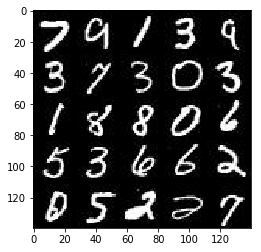

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

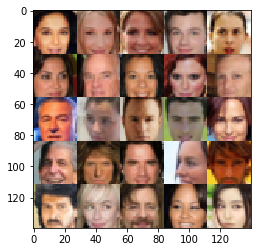

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, in_learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator

Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, stddev=0.02):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 in: 28x28x(1|3)
        layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 14x14x32
        
        # Layer 2: 14x14x32
        layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 7x7x64
        
        layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 4x4x128
        
        layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 2x2x256
        
        flattened = tf.reshape(layer_4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits
        
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1 in: 7x7x256
        layer_1 = tf.layers.dense(z, 4 * 4 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 4x4x512
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 8x8x128
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 16x16x64
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 32x32x32
        
        logits = tf.layers.conv2d_transpose(layer_4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
            
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.9822... Generator Loss: 0.0750
Epoch 1/2... Discriminator Loss: 1.7655... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 2.0640... Generator Loss: 0.2003
Epoch 1/2... Discriminator Loss: 0.5469... Generator Loss: 2.2514
Epoch 1/2... Discriminator Loss: 0.5017... Generator Loss: 3.0328
Epoch 1/2... Discriminator Loss: 1.5120... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 0.4125... Generator Loss: 3.2917
Epoch 1/2... Discriminator Loss: 0.4879... Generator Loss: 2.2174
Epoch 1/2... Discriminator Loss: 2.3055... Generator Loss: 5.8401
Epoch 1/2... Discriminator Loss: 0.9455... Generator Loss: 1.4394


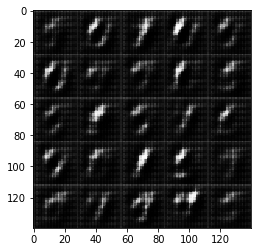

Epoch 1/2... Discriminator Loss: 0.9539... Generator Loss: 1.0024
Epoch 1/2... Discriminator Loss: 1.0657... Generator Loss: 0.8696
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 2.9872
Epoch 1/2... Discriminator Loss: 0.6852... Generator Loss: 2.0302
Epoch 1/2... Discriminator Loss: 0.7612... Generator Loss: 3.1057
Epoch 1/2... Discriminator Loss: 1.5500... Generator Loss: 2.0673
Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 1.3378
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 1.1365
Epoch 1/2... Discriminator Loss: 0.7553... Generator Loss: 1.5990
Epoch 1/2... Discriminator Loss: 0.7936... Generator Loss: 1.2674


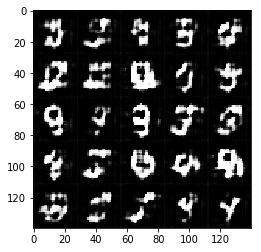

Epoch 1/2... Discriminator Loss: 1.1213... Generator Loss: 0.6938
Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 1.8389
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.1681
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 2.5114
Epoch 1/2... Discriminator Loss: 0.8226... Generator Loss: 1.7082
Epoch 1/2... Discriminator Loss: 0.9290... Generator Loss: 1.2127
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 0.9360
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 0.6671
Epoch 1/2... Discriminator Loss: 1.8235... Generator Loss: 0.3288
Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 0.9375


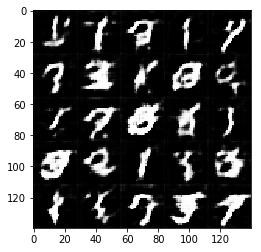

Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.6010
Epoch 1/2... Discriminator Loss: 1.0554... Generator Loss: 1.3612
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 1.0692
Epoch 1/2... Discriminator Loss: 2.0285... Generator Loss: 0.3110
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.4905
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 0.9933
Epoch 1/2... Discriminator Loss: 1.7040... Generator Loss: 0.3452
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.7908
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.9575


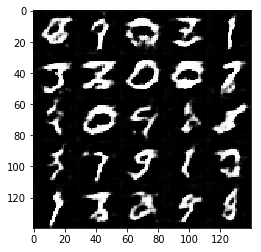

Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 1.1766
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 1.9445
Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 0.6864
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 1.1311
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 1.0816
Epoch 1/2... Discriminator Loss: 1.4767... Generator Loss: 0.4647
Epoch 1/2... Discriminator Loss: 0.8566... Generator Loss: 1.5261
Epoch 1/2... Discriminator Loss: 1.4596... Generator Loss: 1.6640
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.8256
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 0.8811


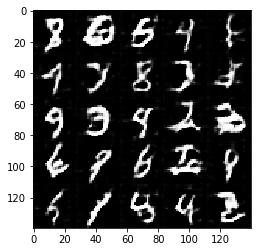

Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 1.5420
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 0.9935
Epoch 1/2... Discriminator Loss: 1.6752... Generator Loss: 0.3699
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 1.0038
Epoch 1/2... Discriminator Loss: 0.9541... Generator Loss: 1.4171
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.4626
Epoch 1/2... Discriminator Loss: 1.0314... Generator Loss: 1.0763
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 0.7022
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.5815


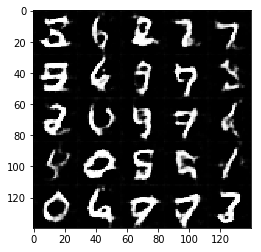

Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 0.7748
Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 1.4113
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.4511
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 0.6092
Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 0.7913
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 1.3959
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.5257
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 0.5385
Epoch 1/2... Discriminator Loss: 0.9008... Generator Loss: 1.1516


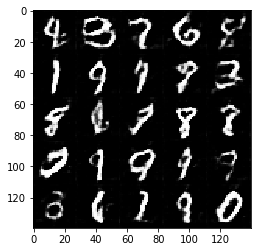

Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 1.0625
Epoch 1/2... Discriminator Loss: 1.4765... Generator Loss: 3.0134
Epoch 1/2... Discriminator Loss: 0.9091... Generator Loss: 1.0425
Epoch 1/2... Discriminator Loss: 1.2694... Generator Loss: 0.6571
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 1.4616
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 1.0050
Epoch 1/2... Discriminator Loss: 1.6039... Generator Loss: 0.3593
Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 1.0033
Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.5285
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 0.5233


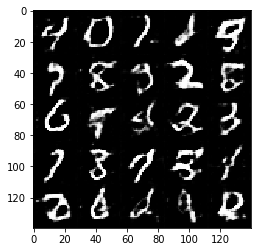

Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 1.4443
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 0.8668
Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 1.6387
Epoch 1/2... Discriminator Loss: 1.6747... Generator Loss: 0.3709
Epoch 1/2... Discriminator Loss: 1.1408... Generator Loss: 0.7264
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 1.3658
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.3633
Epoch 1/2... Discriminator Loss: 1.6841... Generator Loss: 0.3798
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 1.3042... Generator Loss: 0.5505


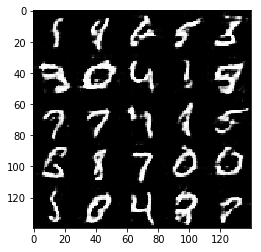

Epoch 1/2... Discriminator Loss: 1.1330... Generator Loss: 1.1121
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 0.6579
Epoch 1/2... Discriminator Loss: 1.9163... Generator Loss: 0.2886
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.6284
Epoch 2/2... Discriminator Loss: 1.0910... Generator Loss: 0.7863
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 1.4813... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.6466... Generator Loss: 0.3673
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 0.5805


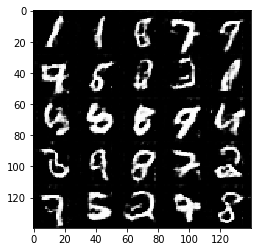

Epoch 2/2... Discriminator Loss: 1.5106... Generator Loss: 0.4377
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.6280
Epoch 2/2... Discriminator Loss: 1.6537... Generator Loss: 0.4057
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.8589
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 2.8473... Generator Loss: 0.1200
Epoch 2/2... Discriminator Loss: 1.0638... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 2.4761... Generator Loss: 0.3437
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 0.8734
Epoch 2/2... Discriminator Loss: 1.2589... Generator Loss: 0.9473


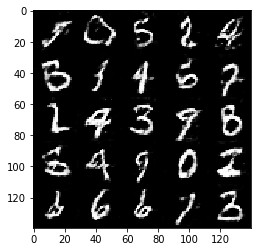

Epoch 2/2... Discriminator Loss: 1.4150... Generator Loss: 1.9358
Epoch 2/2... Discriminator Loss: 1.4802... Generator Loss: 0.4675
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 1.8164
Epoch 2/2... Discriminator Loss: 1.2881... Generator Loss: 1.3094
Epoch 2/2... Discriminator Loss: 1.6592... Generator Loss: 0.3699
Epoch 2/2... Discriminator Loss: 0.9680... Generator Loss: 2.1048
Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 1.0149
Epoch 2/2... Discriminator Loss: 1.3948... Generator Loss: 0.4718
Epoch 2/2... Discriminator Loss: 2.1972... Generator Loss: 0.2127
Epoch 2/2... Discriminator Loss: 1.6872... Generator Loss: 0.3706


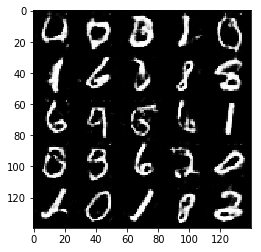

Epoch 2/2... Discriminator Loss: 0.7544... Generator Loss: 1.9618
Epoch 2/2... Discriminator Loss: 1.5325... Generator Loss: 0.4288
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 0.5766
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.4769
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 1.4583
Epoch 2/2... Discriminator Loss: 1.6045... Generator Loss: 0.5693
Epoch 2/2... Discriminator Loss: 1.0346... Generator Loss: 1.0307
Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 2.0797
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.7113


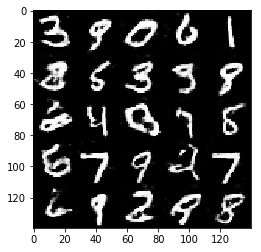

Epoch 2/2... Discriminator Loss: 1.8212... Generator Loss: 0.3284
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 0.7315
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 1.7848... Generator Loss: 0.3253
Epoch 2/2... Discriminator Loss: 1.6874... Generator Loss: 0.3498
Epoch 2/2... Discriminator Loss: 1.4865... Generator Loss: 0.4280
Epoch 2/2... Discriminator Loss: 1.4868... Generator Loss: 0.4963
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 1.1498
Epoch 2/2... Discriminator Loss: 2.2895... Generator Loss: 0.1748


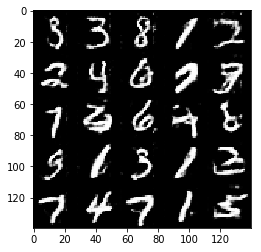

Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 1.1077
Epoch 2/2... Discriminator Loss: 2.2525... Generator Loss: 0.2125
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 1.4538
Epoch 2/2... Discriminator Loss: 2.0072... Generator Loss: 0.2635
Epoch 2/2... Discriminator Loss: 0.9600... Generator Loss: 1.3085
Epoch 2/2... Discriminator Loss: 2.0019... Generator Loss: 0.2462
Epoch 2/2... Discriminator Loss: 2.4317... Generator Loss: 0.1606
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.4767
Epoch 2/2... Discriminator Loss: 2.5862... Generator Loss: 0.1397
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 1.7632


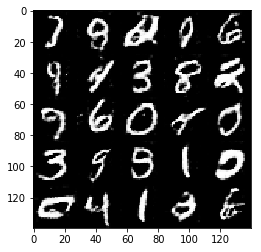

Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.4968
Epoch 2/2... Discriminator Loss: 1.2099... Generator Loss: 0.6224
Epoch 2/2... Discriminator Loss: 1.2333... Generator Loss: 0.5705
Epoch 2/2... Discriminator Loss: 2.3945... Generator Loss: 0.1737
Epoch 2/2... Discriminator Loss: 1.0014... Generator Loss: 1.3766
Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 1.1063... Generator Loss: 1.1001


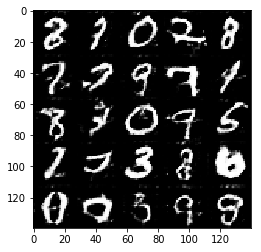

Epoch 2/2... Discriminator Loss: 1.0769... Generator Loss: 0.9059
Epoch 2/2... Discriminator Loss: 1.5498... Generator Loss: 0.6624
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.5255
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.9655
Epoch 2/2... Discriminator Loss: 1.1422... Generator Loss: 0.9479
Epoch 2/2... Discriminator Loss: 1.6540... Generator Loss: 0.4282
Epoch 2/2... Discriminator Loss: 2.0841... Generator Loss: 0.2238
Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 1.6283
Epoch 2/2... Discriminator Loss: 1.1421... Generator Loss: 0.6750
Epoch 2/2... Discriminator Loss: 0.8215... Generator Loss: 1.0753


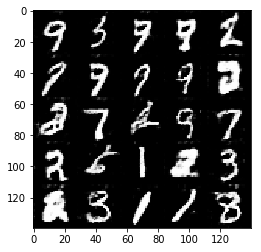

Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 1.6597... Generator Loss: 0.3789
Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 0.5147
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 0.6913
Epoch 2/2... Discriminator Loss: 1.4962... Generator Loss: 0.4422
Epoch 2/2... Discriminator Loss: 0.9361... Generator Loss: 1.4242
Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 1.9565... Generator Loss: 0.2716
Epoch 2/2... Discriminator Loss: 1.6438... Generator Loss: 0.4342
Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 0.5785


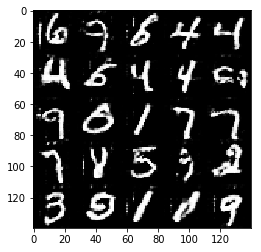

Epoch 2/2... Discriminator Loss: 1.5227... Generator Loss: 0.4166
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 1.0926
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.4895
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 0.9218... Generator Loss: 1.0357
Epoch 2/2... Discriminator Loss: 2.3486... Generator Loss: 0.1885
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 0.5603


In [32]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.3819
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.5494
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 1.9534
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 1.9299
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 2.4046
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 2.5528
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 1.8448
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 2.3529
Epoch 1/1... Discriminator Loss: 0.4904... Generator Loss: 2.7152


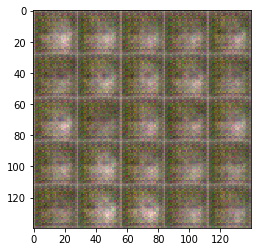

Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.3091
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.5887
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 2.3881
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.7111
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.5654
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.5995
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 1.4899
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.5958
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.7443
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.5964


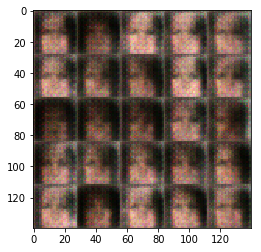

Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 1.6485
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.6497
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.4437
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 1.3497
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.6943
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.7636
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.4457


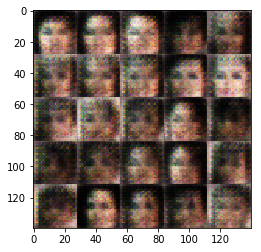

Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.9641
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 2.0119
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.5256
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.6004
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 1.7221
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.8859
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.6180
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.7798


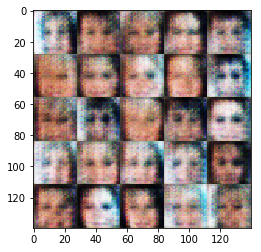

Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.4375
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 2.2661
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 1.6966
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 1.3063


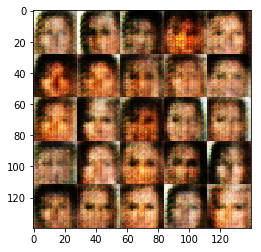

Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.5288
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 2.1386
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.5280
Epoch 1/1... Discriminator Loss: 0.8483... Generator Loss: 1.4355
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.3014
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 1.0715


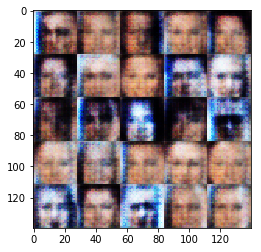

Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.2510
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.3393
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.2282
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.3491
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.6249
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.5062


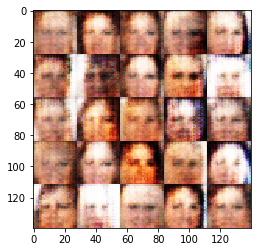

Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.2882
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.9607


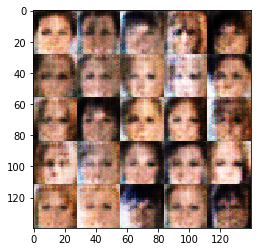

Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 1.3825
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.9602


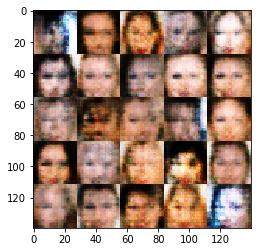

Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.2213
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.2313
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.7168


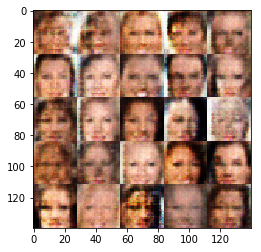

Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.2193
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.6991


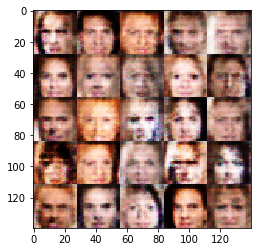

Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.3094
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.2920


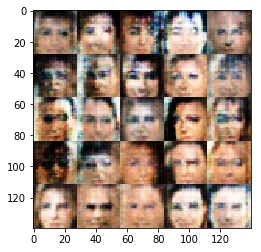

Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.2258
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.4014
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 1.3362


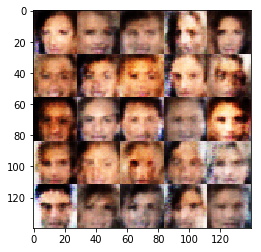

Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.3532
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.3830
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.1146


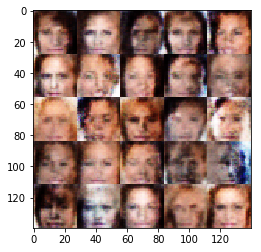

Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.5530
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8157


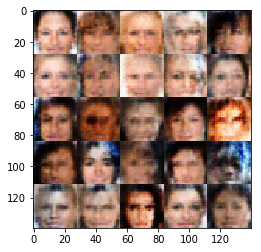

Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.4473
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.8445


In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.